In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
cwd = Path.cwd()
price_path = cwd / 'data' / 'Metro_median_sale_price_now_uc_sfrcondo_month.csv'
zhvi_path = cwd / 'data' / 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (2).csv'

price_df = pd.read_csv(price_path)
zhvi_df = pd.read_csv(zhvi_path)

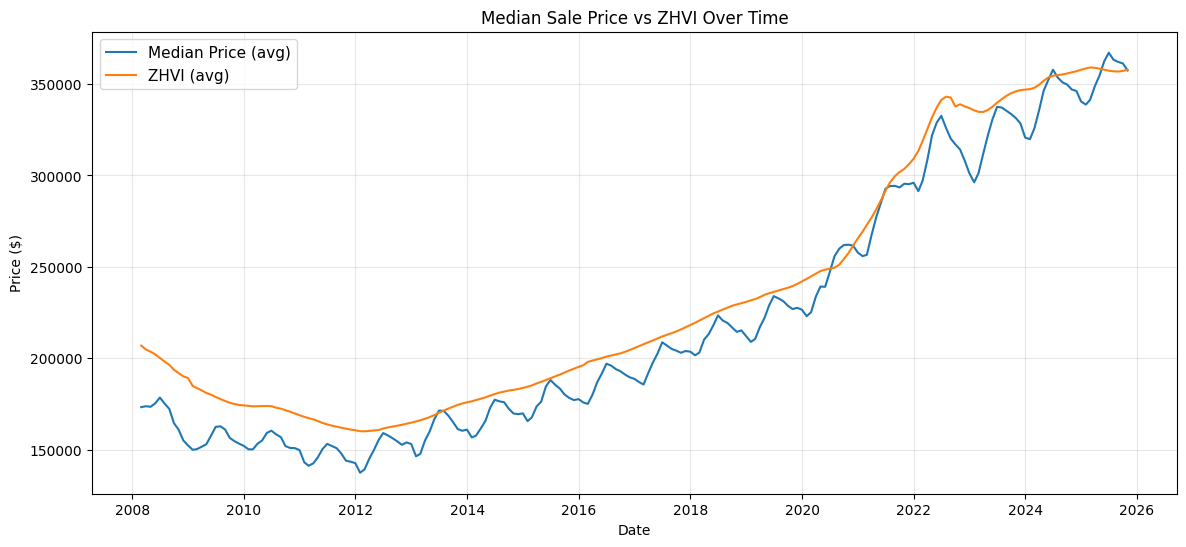

In [10]:
# melt to convert dates to rows
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
price_long = price_df.melt(id_vars=metadata_cols, var_name='date', value_name='median_price')
zhvi_long = zhvi_df.melt(id_vars=metadata_cols, var_name='date', value_name='zhvi')

price_long['date'] = pd.to_datetime(price_long['date'])
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'])

# merge on date and region
merged = pd.merge(price_long[['RegionName', 'date', 'median_price']], 
                  zhvi_long[['RegionName', 'date', 'zhvi']], 
                  on=['RegionName', 'date'], how='inner')

fig, ax = plt.subplots(figsize=(14, 6))
dates = merged['date'].unique()
dates = sorted(dates)

# plot
daily_avg_price = merged.groupby('date')['median_price'].mean()
daily_avg_zhvi = merged.groupby('date')['zhvi'].mean()

ax.plot(daily_avg_price.index, daily_avg_price.values, label='Median Price (avg)')
ax.plot(daily_avg_zhvi.index, daily_avg_zhvi.values, label='ZHVI (avg)')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Median Sale Price vs ZHVI Over Time')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()


Looks like the ZHVI overestimates the Median Sale Price

In [16]:
# melt, clean, merge, and compare price vs ZHVI
price_long['date'] = pd.to_datetime(price_long['date'], errors='coerce')
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'], errors='coerce')

# merge on RegionName and date
price_long['RegionName'] = price_long['RegionName'].astype(str)
zhvi_long['RegionName'] = zhvi_long['RegionName'].astype(str)

merged = pd.merge(price_long, zhvi_long, on=['RegionName','date'], how='inner')

# calculate how far off ZHVI is on average
merged['rel_diff'] = (merged['zhvi'] - merged['median_price']) / merged['median_price']
mean_bias = merged['rel_diff'].mean()


print(f'\nOn average, ZHVI is {abs(mean_bias)*100:.2f}% higher than median sale price')
print(f'Mean bias: {mean_bias:.4f} ({mean_bias*100:.2f}%)')
print(f'Median bias: {merged["rel_diff"].median():.4f} ({merged["rel_diff"].median()*100:.2f}%)')
print(f'Std deviation: {merged["rel_diff"].std():.4f}')
print(f'Sample size: {len(merged)} region-date pairs')


On average, ZHVI is 7.76% higher than median sale price
Mean bias: 0.0776 (7.76%)
Median bias: 0.0661 (6.61%)
Std deviation: 0.1335
Sample size: 82431 region-date pairs
